2025-05-07 10:04:19.656430: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


dict_keys(['__header__', '__version__', '__globals__', 'DM_cal', 'DM_test', 'Sp_cal', 'Sp_test', 'wave', 'SP_all_test', 'SP_all_train'])


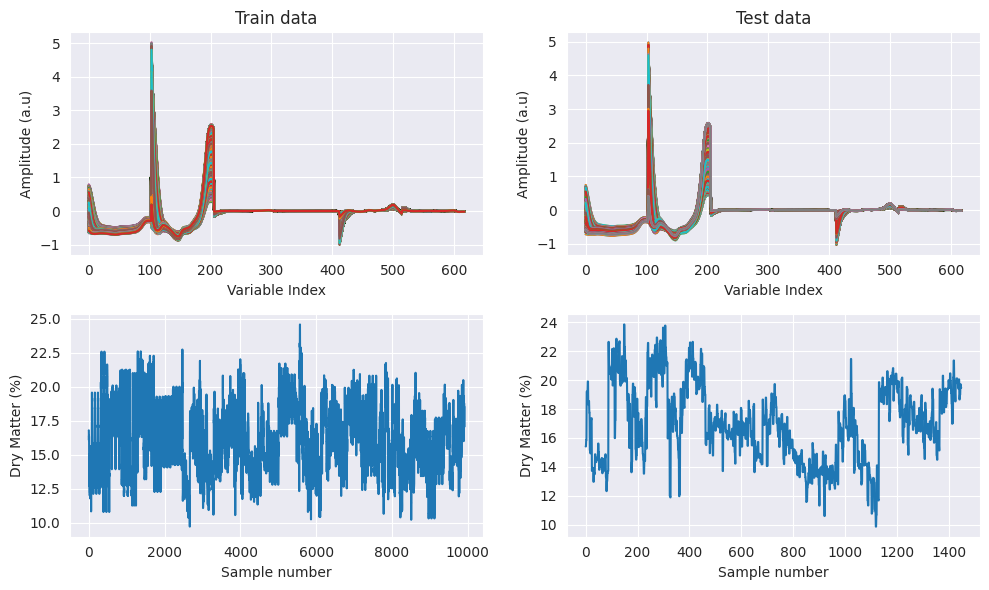

Data set dimensions ----------------------------
Full Train set dims X Y = (9914, 618)	(9914, 1)
Calibration set dims X Y = (7931, 618)	(7931, 1)
val set dims X Y = (1983, 618)	(1983, 1)
Test set dims X Y = (1448, 618)	(1448, 1)
wavelengths number = (103, 1)


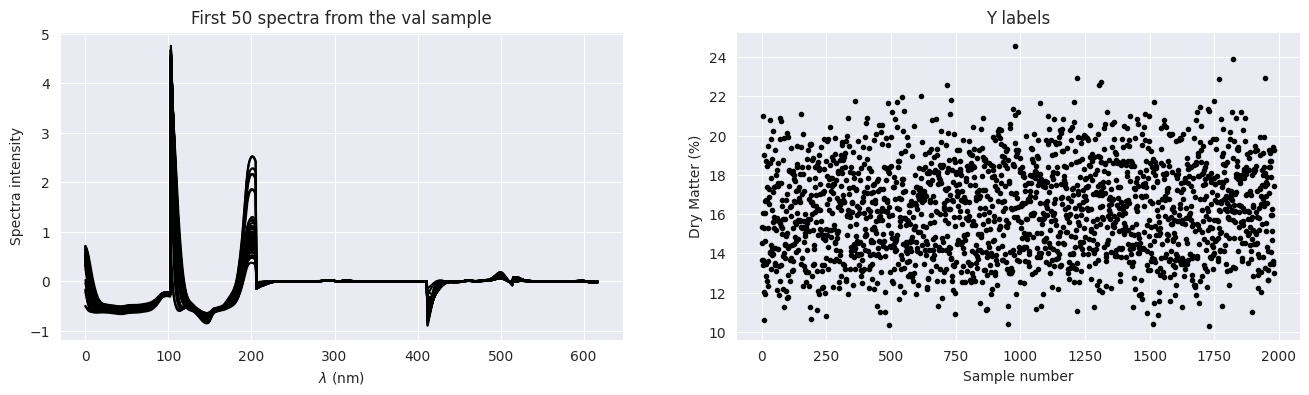

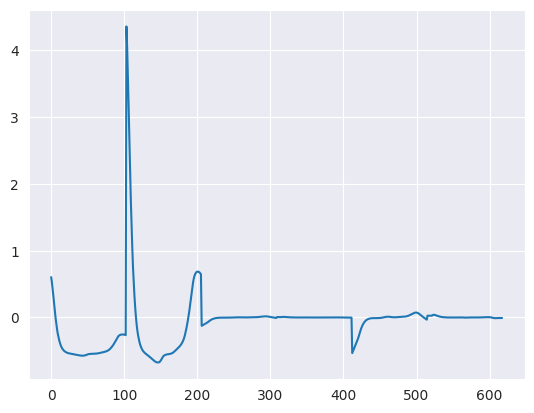

/home/metz/deepchemometrics/Aioly/data/dataset/Mango/models/_DarioNet_Mango/_DarioNet_Mango
Darionet(
  (conv1): Conv1d(1, 1, kernel_size=(45,), stride=(1,), padding=same)
  (fc1): Linear(in_features=618, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (dropout): ManualDropout()
  (output_layer): Linear(in_features=16, out_features=1, bias=True)
)
Epoch 1/1000 | Train Losses: y 0: 22.8994 | Validation Losses: y 0: 2.5547 | R2 Scores: y 0: 0.5387
Epoch 2/1000 | Train Losses: y 0: 2.0334 | Validation Losses: y 0: 1.7759 | R2 Scores: y 0: 0.6862
Epoch 3/1000 | Train Losses: y 0: 1.6026 | Validation Losses: y 0: 1.6555 | R2 Scores: y 0: 0.7020
Epoch 4/1000 | Train Losses: y 0: 1.5390 | Validation Losses: y 0: 1.4686 | R2 Scores: y 0: 0.7353
Epoch 5/1000 | Train Losses: y 0: 1.3963 | Validation Losses: y 0: 1.3461 | R2 Scores: y 0: 0.7418
Epoch 6/1000 | Train Losses: y 0: 1.4025 | Validat

KeyboardInterrupt: 

In [1]:

%load_ext autoreload
%autoreload 2
import torch
import os
import numpy as np
import scipy as sp
from src import utils
from torch import nn
from torch import optim
from src.net import Darionet, CuiNet_orth
from src.utils import ccc, r2_score, RMSEP
import matplotlib.pyplot as plt
from src.training.training import train
from src.data_processing import MangoDataset

import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split

data = sp.io.loadmat("../data/dataset/Mango/mango_dm_full_outlier_removed2.mat")
print(data.keys())

Ycal = data["DM_cal"]
Ytest = data["DM_test"]
Xcal = data["SP_all_train"]
Xtest = data["SP_all_test"]
plt.figure(figsize=(10, 6))
plt.subplot(221)
plt.title('Train data')
plt.plot(Xcal.T)
plt.ylabel('Amplitude (a.u)')
plt.xlabel('Variable Index')
plt.subplot(222)
plt.title('Test data')
plt.plot(Xtest.T)
plt.ylabel('Amplitude (a.u)')
plt.xlabel('Variable Index')
plt.subplot(223)
plt.plot(data['DM_cal'])
plt.ylabel('Dry Matter (%)')
plt.xlabel('Sample number')
plt.subplot(224)
plt.plot(data['DM_test'])
plt.ylabel('Dry Matter (%)')
plt.xlabel('Sample number')
plt.tight_layout()
plt.show()
## Spliting the train set
x_cal, x_val, y_cal, y_val = train_test_split(Xcal, Ycal, test_size=0.20, shuffle=True, random_state=42)

## The wavelenghts for the XX axis when we plot the spectra
x_scale = data['wave'].astype(np.float32).reshape(-1, 1)

## Check for dimensions
print('Data set dimensions ----------------------------')
print('Full Train set dims X Y = {}\t{}'.format(Xcal.shape, Ycal.shape))
print('Calibration set dims X Y = {}\t{}'.format(x_cal.shape, y_cal.shape))
print('val set dims X Y = {}\t{}'.format(x_val.shape, y_val.shape))
print('Test set dims X Y = {}\t{}'.format(Xtest.shape, Ytest.shape))
print('wavelengths number = {}'.format(np.shape(x_scale)))
## Visual data sanity checking for the test set
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(x_val[:50, :].T, 'k')
plt.title('First 50 spectra from the val sample')
plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel('Spectra intensity')
plt.subplot(1, 2, 2)
plt.title('Y labels')
plt.plot(y_val, 'k.')
plt.xlabel('Sample number')
plt.ylabel('Dry Matter (%)')
plt.show()
# calculate mean and std per column

mean = np.mean(x_cal, axis=0)
std = np.std(x_cal, axis=0)

# Convert np.array to Dataloader
# add dt in loader

cal = MangoDataset(x_cal, y_cal, transform=None)
val = data_utils.TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
test_dt = data_utils.TensorDataset(torch.Tensor(Xtest), torch.Tensor(Ytest))

# plot first spectrum output of the cal dataset
x, y = next(iter(cal))
plt.plot(x)
plt.show()
# define model parameters

model_name = "_DarioNet_Mango"
spec_dims = x_cal.shape[1]

num_epochs = 1000
save_interval = 10
BATCH = 128
FILTER_SIZE = 45
L2_BETA = 0.015
LR = 0.002
p = 0.02
data_path = "../data/dataset/Mango/mango_dm_full_outlier_removed2.mat"
save_path = os.path.dirname(os.path.abspath(data_path)) + f'/models/{model_name}/' + model_name
print(save_path)
cal_loader = data_utils.DataLoader(cal, batch_size=BATCH, shuffle=True)
val_loader = data_utils.DataLoader(val, batch_size=BATCH, shuffle=True)
test_loader = data_utils.DataLoader(test_dt, batch_size=BATCH, shuffle=True)

model2 = Darionet(mean=mean, std=std, out_dims=1, filter_size=FILTER_SIZE, reg_beta=L2_BETA, input_dims=spec_dims, p=p)

optimizer = optim.Adam(model2.parameters(), lr=LR, weight_decay=L2_BETA)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=25, factor=0.5, min_lr=1e-6,
                                                       verbose=True)

criterion = nn.MSELoss(reduction='none')
print(model2)
# Train model
train_losses, val_losses, val_r2_scores, final_path = train(model2, optimizer, criterion, cal_loader, val_loader,
                                                            num_epochs, save_path=save_path,
                                                            save_interval=save_interval, early_stop=False,
                                                            scheduler=scheduler)

print(max(val_r2_scores))
utils.test(model2, final_path, test_loader)
# création d'une boucle de prédiction pour réalisation du MC dropout
model2.eval()
model2.load_state_dict(torch.load(final_path))
model2.to("cuda")
dt = torch.Tensor(Xtest).to("cuda")
# création d'une boucle de 100 itérations pour réaliser le MC dropout
n_iter = 100
y_preds = []
for i in range(n_iter):
    with torch.no_grad():
        y_pred = model2.forward(dt[:, None])
    y_preds.append(y_pred)

y_preds = torch.stack(y_preds)

# moyenne des prédictions et écart type
y_pred = y_preds.mean(dim=0)
y_std = y_preds.std(dim=0)
# plot des prédiction en fonction des observations puis calcul du CCC, R2, etc
y_pred = np.squeeze(np.array(y_pred.detach().cpu()))
y_std = np.squeeze(np.array(y_std.detach().cpu()))
Ytest = np.squeeze(Ytest)
y_std = y_std.reshape(-1)

# Calcul des métriques
print("CCC: %5.5f, R2: %5.5f, RMSEP: %5.5f" % (ccc(y_pred, Ytest), r2_score(Ytest, y_pred), RMSEP(y_pred, Ytest)))

# plot des prédictions en fonction des observations avec l'écart-type en transparence avec plt.errorbar
plt.figure(figsize=(8, 6))

# Scatter plot des observations et des prédictions
plt.scatter(Ytest, y_pred, edgecolors='k', alpha=0.5)

# Ajout des barres d'erreur représentant l'intervalle de confiance à 95%
plt.errorbar(Ytest, y_pred, yerr=1.9600 * y_std, fmt='o', color='r', alpha=0.2, label='95% confidence interval')

# Ligne rouge correspondant à y=x pour comparaison
plt.plot([Ytest.min() - 1, Ytest.max() + 1], [Ytest.min() - 1, Ytest.max() + 1], 'r')

# Ajout des métriques au graphique
plt.text(0.1 * Ytest.max(), 0.9 * Ytest.max(),
         "CCC: %5.5f" % (ccc(Ytest, y_pred)) + "\nR2: %5.5f" % (r2_score(Ytest, y_pred)) + "\nRMSEP: %5.5f" % (
             RMSEP(Ytest, y_pred)),
         fontsize=16, bbox=dict(facecolor='white', alpha=0.5))

# Paramètres du graphique
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Observed', fontsize=16)
plt.ylabel('Predicted', fontsize=16)
plt.legend(fontsize=14)
plt.show(block=False)

CuiNet_orth(
  (dropout): ManualDropout()
  (conv1d): Conv1d(1, 1, kernel_size=(5,), stride=(1,))
  (fc1): Linear(in_features=614, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=18, bias=True)
  (fc3): Linear(in_features=18, out_features=12, bias=True)
  (out): Linear(in_features=12, out_features=1, bias=True)
)
Epoch 1/1000 | Train Losses: y 0: 42157.9180 | Validation Losses: y 0: 1790.0798 | R2 Scores: y 0: 0.0050
Epoch 2/1000 | Train Losses: y 0: 992.7955 | Validation Losses: y 0: 835.2497 | R2 Scores: y 0: 0.0007
Epoch 3/1000 | Train Losses: y 0: 633.2477 | Validation Losses: y 0: 690.8989 | R2 Scores: y 0: -0.0033
Epoch 4/1000 | Train Losses: y 0: 434.1930 | Validation Losses: y 0: 343.1384 | R2 Scores: y 0: -0.0000
Epoch 5/1000 | Train Losses: y 0: 316.0912 | Validation Losses: y 0: 263.2693 | R2 Scores: y 0: -0.0012
Epoch 6/1000 | Train Losses: y 0: 279.6770 | Validation Losses: y 0: 230.7152 | R2 Scores: y 0: -0.0046
Epoch 7/1000 | Train Losses: y 0: 2

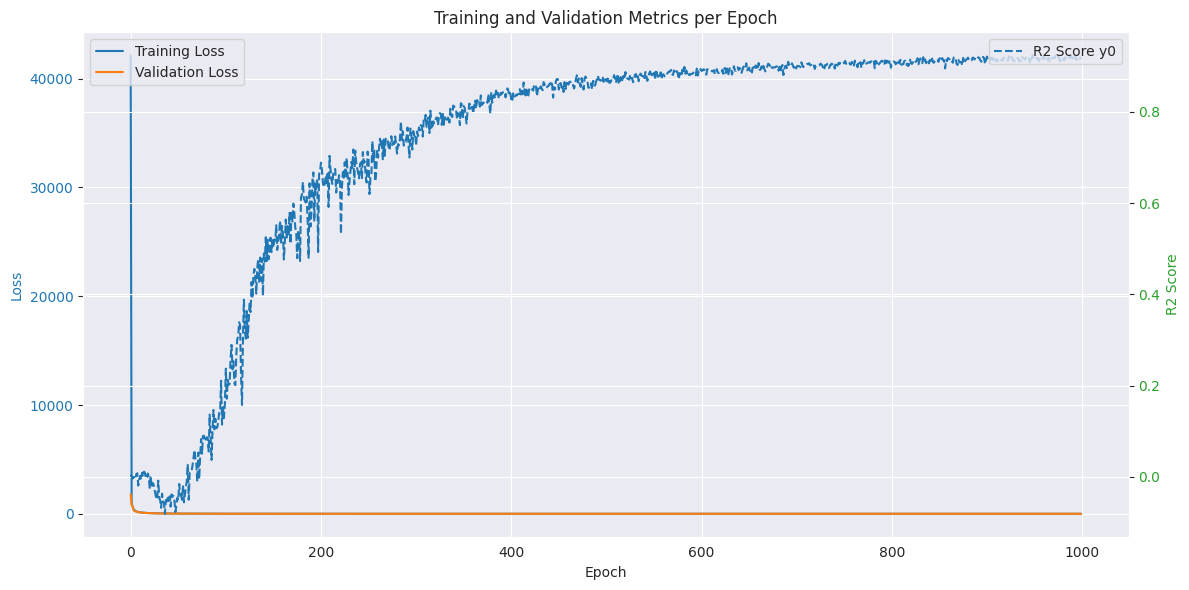

In [2]:
model_name = "_CuiNet_Mango_orthog"
spec_dims = x_cal.shape[1]
LR = 0.001
num_epochs = 1000
save_interval = 10
BATCH = 128
cal_loader = data_utils.DataLoader(cal, batch_size=BATCH, shuffle=True)
val_loader = data_utils.DataLoader(val, batch_size=BATCH, shuffle=True)
test_loader = data_utils.DataLoader(test_dt, batch_size=BATCH, shuffle=True)
data_path = "/data/dataset/Mango/mango_dm_full_outlier_removed2.mat"
save_path = os.path.dirname(os.path.abspath(data_path)) + f'/models/{model_name}/' + model_name

model = CuiNet_orth(spec_dims, mean=mean, std=std, out_dims=1, dropout=0.02,orthog_dims=4)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss(reduction='none')
print(model)

train_losses, val_losses, val_r2_scores, final_path = train(model, optimizer, criterion, cal_loader, val_loader,
                                                            num_epochs, save_path=save_path,
                                                            save_interval=save_interval, early_stop=False)


[0.9236133098602295]
CCC: 0.9330627718497136, R2: 0.8712141513824463, RMSEP: 0.9576713442802429


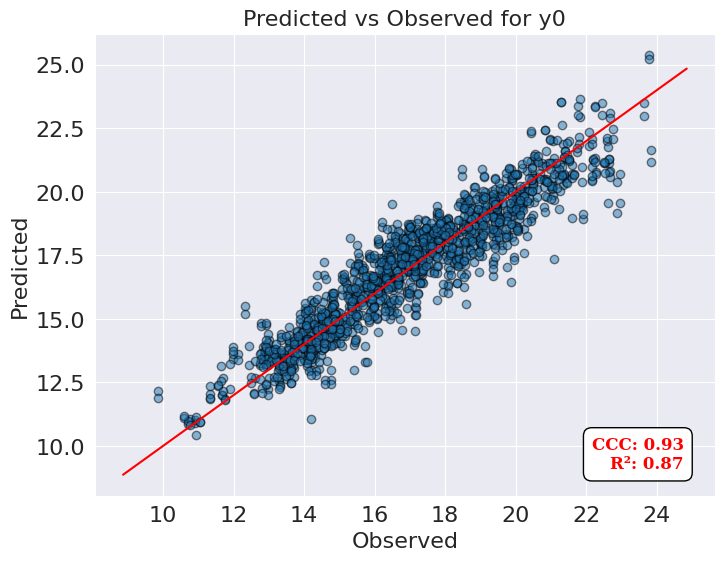

NameError: name 'y_preds' is not defined

In [3]:
print(max(val_r2_scores))
utils.test(model, final_path, test_loader)
# création d'une boucle de prédiction pour réalisation du MC dropout
model.eval()
model.load_state_dict(torch.load(final_path))
model.to("cpu")
dt = torch.Tensor(Xtest).to("cpu")
# création d'une boucle de 100 itérations pour réaliser le MC dropout


y_preds = torch.stack(y_preds)

# moyenne des prédictions et écart type
y_pred = y_preds.mean(dim=0)
y_pred = np.squeeze(np.array(y_pred.detach().cpu()))
Ytest = np.squeeze(Ytest)


# Calcul des métriques
print("CCC: %5.5f, R2: %5.5f, RMSEP: %5.5f" % (ccc(y_pred, Ytest), r2_score(Ytest, y_pred), RMSEP(y_pred, Ytest)))

# plot des prédictions en fonction des observations avec l'écart-type en transparence avec plt.errorbar
plt.figure(figsize=(8, 6))

# Scatter plot des observations et des prédictions
plt.scatter(Ytest, y_pred, edgecolors='k', alpha=0.5)

# Ajout des barres d'erreur représentant l'intervalle de confiance à 95%
plt.errorbar(Ytest, y_pred, yerr=1.9600 * y_std, fmt='o', color='r', alpha=0.2, label='95% confidence interval')

# Ligne rouge correspondant à y=x pour comparaison
plt.plot([Ytest.min() - 1, Ytest.max() + 1], [Ytest.min() - 1, Ytest.max() + 1], 'r')

# Ajout des métriques au graphique
plt.text(0.1 * Ytest.max(), 0.9 * Ytest.max(),
         "CCC: %5.5f" % (ccc(Ytest, y_pred)) + "\nR2: %5.5f" % (r2_score(Ytest, y_pred)) + "\nRMSEP: %5.5f" % (
             RMSEP(Ytest, y_pred)),
         fontsize=16, bbox=dict(facecolor='white', alpha=0.5))

# Paramètres du graphique
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Observed', fontsize=16)
plt.ylabel('Predicted', fontsize=16)
plt.legend(fontsize=14)
plt.show(block=False)

In [4]:
# Nombre de morceaux (bins) que tu veux pour diviser Ytest
n_bins = 30

# Découpage des données en bins selon les valeurs de Ytest
bins = np.linspace(Ytest.min(), Ytest.max(), n_bins + 1)
indices = np.digitize(Ytest, bins)

# Initialisation des listes pour stocker les résultats
bin_centers = []
bin_rmse = []
bin_mean_std = []  # Moyenne des écarts-types dans chaque bin

# Calcul de l'erreur (RMSE) et de l'écart-type moyen dans chaque bin
for i in range(1, n_bins + 1):
    # Sélection des indices des données appartenant au bin courant
    bin_indices = np.where(indices == i)[0]

    if len(bin_indices) > 0:  # Vérification qu'il y a des points dans ce bin
        y_pred_bin = y_pred[bin_indices]
        Ytest_bin = Ytest[bin_indices]
        y_std_bin = y_std[bin_indices]

        # Calcul du RMSE dans ce bin
        rmse = np.sqrt(RMSEP(Ytest_bin, y_pred_bin))

        # Calcul de l'écart-type moyen dans ce bin
        mean_std = np.mean(y_std_bin)

        # Centre du bin (pour l'axe des x)
        bin_center = (bins[i - 1] + bins[i]) / 2

        # Stocker les résultats
        bin_centers.append(bin_center)
        bin_rmse.append(rmse)
        bin_mean_std.append(mean_std)

# Tracé de l'erreur par bin (RMSE et écart-type moyen)
plt.figure(figsize=(10, 6))

# Tracé du RMSE par bin
plt.plot(bin_centers, bin_rmse, marker='o', linestyle='-', color='b', label='RMSE')

# Ajout de la bande d'incertitude autour de la ligne de RMSE (RMSE ± moyenne des écarts-types)
plt.fill_between(bin_centers,
                 np.array(bin_rmse) - np.array(bin_mean_std),
                 np.array(bin_rmse) + np.array(bin_mean_std),
                 color='blue', alpha=0.2, label='RMSE ± Std Deviation')

# Ajout des labels et de la légende
plt.xlabel('Value of Ytest (bin center)', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.title('Global Estimation of Error by Bin with Confidence Bands', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

n_iter = 1000
y_preds = []
for i in range(n_iter):
    with torch.no_grad():
        y_pred = model.forward(dt[:, None])
    y_preds.append(y_pred)

y_preds = torch.stack(y_preds)

# moyenne des prédictions et écart type
y_pred1 = y_preds.mean(dim=0)
y_std1 = y_preds.std(dim=0)
# plot des prédiction en fonction des observations puis calcul du CCC, R2, etc
y_pred1 = np.squeeze(np.array(y_pred1.detach().cpu()))
y_std1 = np.squeeze(np.array(y_std1.detach().cpu()))
Ytest = np.squeeze(Ytest)
y_std1 = y_std1.reshape(-1)

n_iter = 1000
y_preds = []
for i in range(n_iter):
    with torch.no_grad():
        y_pred = model2.forward(dt[:, None])
    y_preds.append(y_pred)

y_preds = torch.stack(y_preds)

# moyenne des prédictions et écart type
y_pred2 = y_preds.mean(dim=0)
y_std2 = y_preds.std(dim=0)
# plot des prédiction en fonction des observations puis calcul du CCC, R2, etc
y_pred2 = np.squeeze(np.array(y_pred2.detach().cpu()))
y_std2 = np.squeeze(np.array(y_std2.detach().cpu()))
y_std2 = y_std2.reshape(-1)
print(RMSEP(Ytest, y_pred2))

# Nombre de morceaux (bins) pour diviser Ytest
n_bins = 30

# Découpage des données en bins selon les valeurs de Ytest
bins = np.linspace(Ytest.min(), Ytest.max(), n_bins + 1)
indices = np.digitize(Ytest, bins)

# Initialisation des listes pour stocker les résultats pour y_pred1 et y_pred2
bin_centers = []
bin_rmse1 = []
bin_rmse2 = []
bin_mean_std1 = []  # Moyenne des écarts-types pour y_pred1 dans chaque bin
bin_mean_std2 = []  # Moyenne des écarts-types pour y_pred2 dans chaque bin

# Calcul de l'erreur (RMSE) et de l'écart-type moyen dans chaque bin
for i in range(1, n_bins + 1):
    # Sélection des indices des données appartenant au bin courant
    bin_indices = np.where(indices == i)[0]

    if len(bin_indices) > 0:  # Vérification qu'il y a des points dans ce bin
        # Données pour le bin courant
        Ytest_bin = Ytest[bin_indices]

        # Prédiction 1
        y_pred_bin1 = y_pred1[bin_indices]
        y_std_bin1 = y_std1[bin_indices]  # Ecart-type pour y_pred1
        rmse1 = np.sqrt(RMSEP(Ytest_bin, y_pred_bin1))
        mean_std1 = np.mean(y_std_bin1)

        # Prédiction 2
        y_pred_bin2 = y_pred2[bin_indices]
        y_std_bin2 = y_std2[bin_indices]  # Ecart-type pour y_pred2
        rmse2 = np.sqrt(RMSEP(Ytest_bin, y_pred_bin2))
        mean_std2 = np.mean(y_std_bin2)

        # Centre du bin (pour l'axe des x)
        bin_center = (bins[i - 1] + bins[i]) / 2

        # Stocker les résultats
        bin_centers.append(bin_center)
        bin_rmse1.append(rmse1)
        bin_mean_std1.append(mean_std1)
        bin_rmse2.append(rmse2)
        bin_mean_std2.append(mean_std2)

# Tracé des erreurs par bin pour y_pred1 et y_pred2
plt.figure(figsize=(10, 6))

# Tracé du RMSE par bin pour y_pred1
plt.plot(bin_centers, bin_rmse1, marker='o', linestyle='-', color='b', label='RMSE y_pred1')
plt.fill_between(bin_centers,
                 np.array(bin_rmse1) - np.array(bin_mean_std1),
                 np.array(bin_rmse1) + np.array(bin_mean_std1),
                 color='blue', alpha=0.2, label='RMSE ± Std Deviation y_pred1')

# Tracé du RMSE par bin pour y_pred2
plt.plot(bin_centers, bin_rmse2, marker='o', linestyle='-', color='r', label='RMSE y_pred2')
plt.fill_between(bin_centers,
                 np.array(bin_rmse2) - np.array(bin_mean_std2),
                 np.array(bin_rmse2) + np.array(bin_mean_std2),
                 color='red', alpha=0.2, label='RMSE ± Std Deviation y_pred2')

# Ajout des labels et de la légende
plt.xlabel('Value of Ytest (bin center)', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.title('Global Estimation of Error by Bin for y_pred1 and y_pred2', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()



NameError: name 'y_pred' is not defined